# Projet Deep Learning : Luc Yao, Léos Coutrot, Jaad Belhouari

### UNSUPERVISED DATA AUGMENTATION FOR CONSISTENCY TRAINING

### 0. Settings 

#### 0.1. Imports

In [1]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library

# Metrics and confusion matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Train/test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# To count the number of element in each class
from collections import Counter

# make our loops show a smart progress
from tqdm import tqdm

import os

In [2]:
# Pytorch libraries

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset

import torch.optim as optim

from torch.optim import Adam

#### 0.2. Connexion to GPU

In [3]:
# Check if  is using GPU acceleration
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [4]:
print(torch.cuda.current_device())  # Prints the index of the current device
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # Prints the name of the active device

0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [5]:
print(torch.version.cuda)

11.8


#### 0.3. Usefull functions

In [9]:
# Function to get the accuracy
def get_accuracy(y_true, y_pred):
    """
    Get accuracy from classification report.
    
    Args:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    
    Returns:
    - float: Accuracy.
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    return accuracy

In [8]:
# Function to plot confusion matrix in a proper manner
def plot_confusion_matrix(y_true, y_pred):
    
    """
    Plot a confusion matrix in a sexy manner.
    
    Args:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    
    Returns:
    - None
    """
   
    # getting min and max values
    min_label = min([np.min(y_true), np.min(y_pred)])
    max_label = max([np.max(y_true), np.max(y_pred)])
    # list of our test labels
    labels_test = [x for x in range(int(min_label), int(max_label)+1)]

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()

    classes = np.unique(labels_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            color = "white" if conf_matrix[i, j] > thresh else "black"
            if i == j:  # Highlight diagonal cells
                plt.text(j, i, format(conf_matrix[i, j], 'd'),
                        ha="center", va="center", color="red", fontsize=12)
            else:
                plt.text(j, i, format(conf_matrix[i, j], 'd'),
                        ha="center", va="center", color=color)
    plt.ylabel('True Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)

In [10]:
# Function to reverse normalization for display
def denormalize(tensor, mean=(0.5,), std=(0.5,)):
    """
    Denormalizes a normalized tensor for visualization.

    Args:
        tensor (Tensor): Normalized tensor.
        mean (tuple): Mean used for normalization.
        std (tuple): Std deviation used for normalization.

    Returns:
        Tensor: Denormalized tensor.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # reverse normalization
    return tensor

# Visualize a sample image
def visualize_transformed_data(augmented_data, i):
    """
    Visualizes a transformed image from the augmented data.

    Args:
        augmented_data (list): List of (image, label) pairs.
    """
    # Get the first image-label pair
    transformed_image, label = augmented_data[i]  # Assuming it's a tensor
    denorm_image = denormalize(transformed_image.clone())  # Clone to avoid modifying the original tensor
    np_image = denorm_image.numpy()  # Convert to numpy array

    # Remove the channel dimension for grayscale image
    np_image = np.squeeze(np_image)

    # Display the image
    plt.imshow(np_image, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

In [11]:
def evaluate_test_data(model, test_loader, device):
    """
    Evaluates the trained model on the test dataset and prints a classification report.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: Device to run the evaluation on (e.g., "cuda" or "cpu").
    """
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    # Define the output activation function
    output_fn = nn.Softmax(dim=1)  # Assuming classification task with softmax outputs

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            predictions = output_fn(outputs).argmax(dim=1)  # Get the index of the max log-probability
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute and print detailed classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Confusion matrix 
    plot_confusion_matrix(all_labels, all_predictions)

In [12]:
# Function to create augmented dataset
def create_augmented_dataset(dataset, indices, augment_transform, target_size=1000):
    augmented_images = []
    augmented_labels = []

    original_subset = Subset(dataset, indices)
    while len(augmented_images) < target_size:
        for image, label in original_subset:
            # Convert tensor back to PIL Image for augmentation
            image_pil = transforms.ToPILImage()(image)
            augmented_image = augment_transform(image_pil)  # Apply the transformation pipeline
            augmented_images.append(augmented_image)
            augmented_labels.append(label)
            if len(augmented_images) >= target_size:
                break

    return list(zip(augmented_images, augmented_labels))

### 1. Baseline model 

#### 1.1. Data Loading

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])

batch_size = 64

dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

In [14]:
# Vizualisation of the test data
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

#### Number of elements in each class

In [15]:
classes = dataset.classes

class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'5 - five': 5421,
 '0 - zero': 5923,
 '4 - four': 5842,
 '1 - one': 6742,
 '9 - nine': 5949,
 '2 - two': 5958,
 '3 - three': 6131,
 '6 - six': 5918,
 '7 - seven': 6265,
 '8 - eight': 5851}

In [16]:
# Spliting the training set into training and validation data
random_state = 42 #for reproductible results
train_indices, val_indices = train_test_split(list(range(len(dataset.targets))),
                                              test_size=10000,
                                              stratify=dataset.targets,
                                              random_state=random_state)

trainset = torch.utils.data.Subset(dataset, train_indices)
valset = torch.utils.data.Subset(dataset, val_indices)

#### 1.2. Data Loader

In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#### 1.3. Model Building

As our data are images, we decide to build a Convolutional Neural Network for our classification task.
Therefore, let's first train a baseline "naive" model, only using 100 labeled images with no :
- data augmentation 
- semi-supervised learning techniques

To se how our model perform in this case to prove that the previous techniques are indeed needed to improve significantly the performances.

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # always subclass
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same") # first conv layer
        # the three arguments in_channels, out_channels, kernel_size must be filled, the others are optionnal and have default values
        # out_channels correspond to the number of filters
        # if heigth=width in the kernel size, just set one value instead of a tuple
        # stride is set to 1 by default
        # padding='same' pads the input so the output has the shape as the input. However, this mode doesn’t support any stride values other than 1.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding="same") # second conv layer
        self.pool = nn.MaxPool2d(kernel_size=2) # maxpooling
        self.dp1 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(in_features=32 * 14 * 14, out_features=512) # linear layer after flattening
        self.dp2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=10) # we have 10 probability classes to predict so 10 output features

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dp1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dp2(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

device = torch.device("cuda")
net = Net().to(device) # train on GPU if available

In [19]:
print(net) # similar to `model.summary` in keras
print("(model mem allocation) - Memory available : {:.2e}".format(torch.cuda.memory_reserved(0)-torch.cuda.memory_allocated(0)))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
(model mem allocation) - Memory available : 3.87e+06


In [20]:
# Extract labels from the dataset
labels = [trainset[i][1] for i in range(len(trainset))]  # Extract class labels

# Use StratifiedShuffleSplit to get stratified indices
num_samples = 100  # Total number of samples
sss = StratifiedShuffleSplit(n_splits=1, test_size=num_samples, random_state=42)
_, indices = next(sss.split(X=range(len(trainset)), y=labels))  # Split indices

# Create a subset with the stratified indices
stratified_subset = Subset(trainset, indices)

# Create a DataLoader for the subset
batch_size = 32
stratified_loader = DataLoader(stratified_subset, batch_size=batch_size, shuffle=True)

In [21]:
print("The number of labeled data fro training is :", len(stratified_subset))

The number of labeled data fro training is : 100


In [22]:
class_counts = Counter([stratified_subset[i][1] for i in range(len(stratified_subset))])
class_counts

Counter({1: 11, 6: 10, 8: 10, 2: 10, 9: 10, 7: 10, 0: 10, 3: 10, 4: 10, 5: 9})

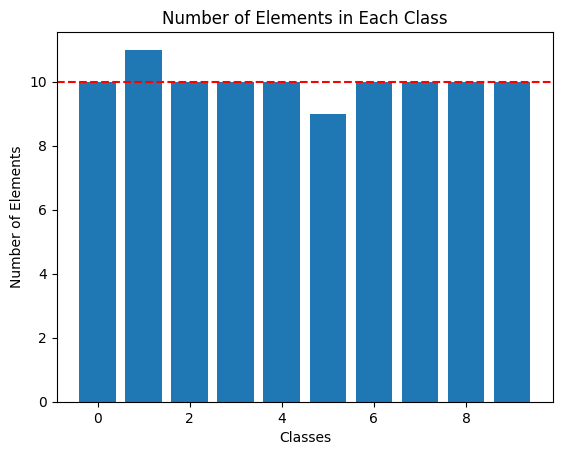

In [23]:
# Visualization with barplot 

# Extracting the classes and their counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Creating the barplot
plt.bar(classes, counts)

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Elements')
# Adding a horizontal line at y=5 (for example) 
plt.axhline(y=len(stratified_subset)/len(classes), color='r', linestyle='--')
plt.title('Number of Elements in Each Class')

# Display the plot
plt.show()

Our labels are balancely distributed over all classes.

#### 1.4. Model training 

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Init
epochs = 20
output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
criterion = nn.CrossEntropyLoss() # we instantiate the loss function
optimizer = optim.Adam(net.parameters(), lr=0.001) # we instantiate Adam optimizer that takes as inputs the model parameters and learning rate

# Move the model to the GPU
net.to(device)

loss_valid,acc_valid =[],[]
loss_train,acc_train =[],[]

for epoch in tqdm(range(epochs)):

  # Training loop
  net.train() # always specify that the model is in training mode
  running_loss = 0.0 # init loss
  running_acc = 0.

  # Loop over batches returned by the data loader
  for idx, batch in enumerate(stratified_loader):

    # get the inputs; batch is a tuple of (inputs, labels)
    inputs, labels = batch
    inputs = inputs.to(device) # put the data on the same device as the model
    labels = labels.to(device)

    # put to zero the parameters gradients at each iteration to avoid accumulations
    optimizer.zero_grad()

    # forward pass + backward pass + update the model parameters
    out = net(x=inputs) # get predictions
    loss = criterion(out, labels) # compute loss
    loss.backward() # compute gradients
    optimizer.step() # update model parameters according to these gradients and our optimizer strategy

    # Iteration train metrics
    running_loss += loss.view(1).item()
    t_out = output_fn(out.detach()).cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
    t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
    ground_truth = labels.cpu().numpy() # detach the labels from GPU device
    running_acc += get_accuracy(ground_truth, t_out)

  ### Epochs train metrics ###
  acc_train.append(running_acc/len(stratified_loader))
  loss_train.append(running_loss/len(stratified_loader))

  # compute loss and accuracy after an epoch on the train and valid set
  net.eval() # put the model in evaluation mode (this prevents the use of dropout layers for instance)

  ### VALIDATION DATA ###
  with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    idx = 0
    for batch in valloader:
      inputs,labels=batch
      inputs=inputs.to(device)
      labels=labels.to(device)
      if idx==0:
        t_out = net(x=inputs)
        t_loss = criterion(t_out, labels).view(1).item()
        t_out = output_fn(t_out).detach().cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
        t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
        ground_truth = labels.cpu().numpy() # detach the labels from GPU device
      else:
        out = net(x=inputs)
        t_loss = np.hstack((t_loss,criterion(out, labels).item()))
        t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
      idx+=1

    acc_valid.append(get_accuracy(ground_truth,t_out))
    loss_valid.append(np.mean(t_loss))

  print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
      '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))

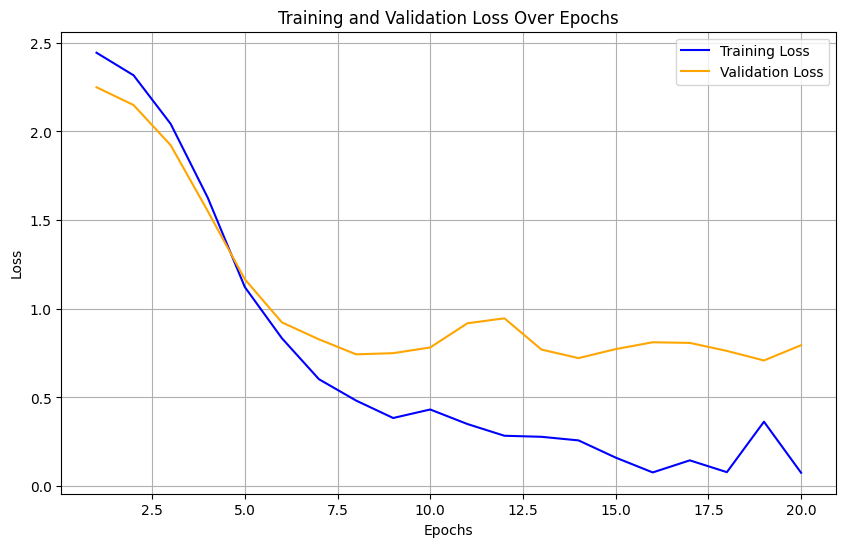

In [32]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_train, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), loss_valid, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

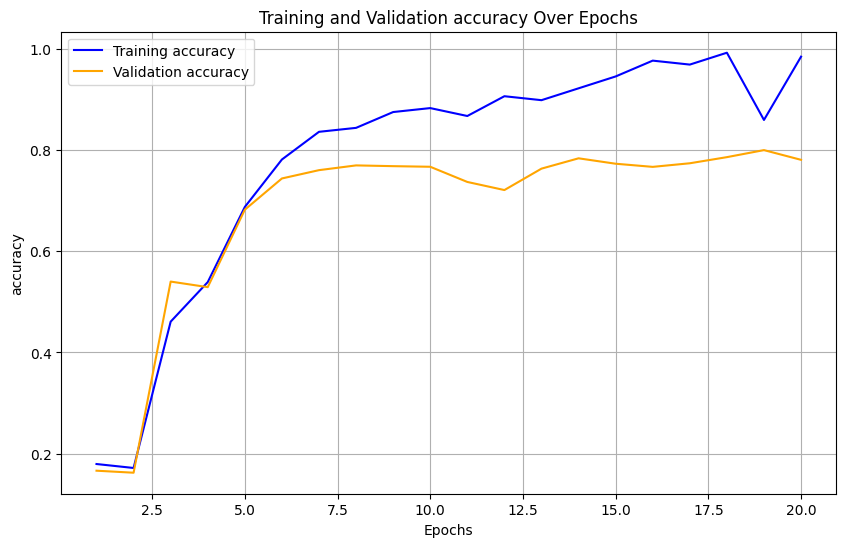

In [33]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), acc_train, label='Training accuracy', color='blue')
plt.plot(range(1, epochs + 1), acc_valid, label='Validation accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### 1.5. Model Evaluation

In [34]:
# Evaluate on test data
net.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

output_fn = torch.nn.Softmax(dim=1)  # Instantiate the softmax function for predictions

with torch.no_grad():  # No need to calculate gradients
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute predictions and accuracy
        predictions = output_fn(outputs).argmax(dim=1)  # Get predicted class
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Compute final metrics
average_test_loss = test_loss / len(testloader)
test_accuracy = correct / total

print(f'Test Loss: {average_test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.7514
Test Accuracy: 0.7938


In [35]:
# After collecting all predictions and ground truth
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        predictions = output_fn(outputs).argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute detailed classification report
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.97      0.69      0.80       980
           1       0.96      0.97      0.97      1135
           2       0.83      0.74      0.78      1032
           3       0.77      0.80      0.78      1010
           4       0.85      0.79      0.82       982
           5       0.68      0.75      0.72       892
           6       0.67      0.96      0.79       958
           7       0.80      0.89      0.84      1028
           8       0.90      0.53      0.66       974
           9       0.66      0.79      0.72      1009

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.81      0.79      0.79     10000



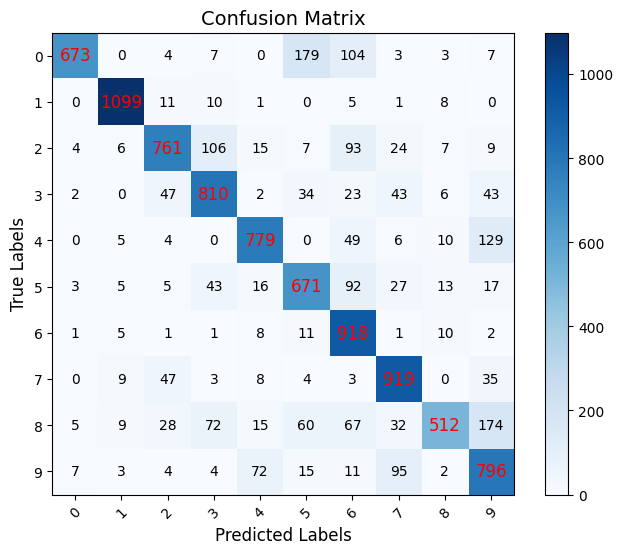

In [36]:
# Confusion matrix 
plot_confusion_matrix(all_labels, all_predictions)

### 2. RandAugment method

#### 2.1. Building new class for semi-supervised technics

In [38]:

import matplotlib.pyplot as plt

class SemiSupervisedTrainer:
    def __init__(self, model, device, config):
        self.model = model.to(device)
        self.device = device
        self.config = config

        # Define the optimizer, scheduler, and loss functions
        self.optimizer = optim.SGD(
            model.parameters(), 
            lr=config["learning_rate"], 
            momentum=0.9, 
            weight_decay=config["weight_decay"]
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, 
            T_max=config["train_steps"]
        )
        self.supervised_criterion = nn.CrossEntropyLoss()
        self.kl_divergence = nn.KLDivLoss(reduction='batchmean')

        # Initialize lists to store losses
        self.training_loss_history = []
        self.supervised_loss_history = []
        self.unsupervised_loss_history = []
        self.validation_loss_history = []

    def train(self, labeled_dataset, unlabeled_dataset, val_dataset):
        labeled_loader = DataLoader(labeled_dataset, batch_size=self.config["train_batch_size"], shuffle=True)
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=self.config["unsup_batch_size"], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config["eval_batch_size"], shuffle=False)

        unlabeled_iter = iter(unlabeled_loader)

        for step in range(self.config["train_steps"]):
            self.model.train()
            
            # Initialize accumulators for step losses
            total_loss_accumulator = 0.0
            supervised_loss_accumulator = 0.0
            unsupervised_loss_accumulator = 0.0
            batch_count = 0

            for labeled_data in labeled_loader:
                images_sup, labels_sup = labeled_data
                images_sup, labels_sup = images_sup.to(self.device), labels_sup.to(self.device)

                # if unlabeled_iter is None or not hasattr(unlabeled_iter, "__next__"):
                #     unlabeled_iter = iter(unlabeled_loader)
    
                try:
                    images_unsup = next(unlabeled_iter)
                except StopIteration:
                    unlabeled_iter = iter(unlabeled_loader)
                    images_unsup = next(unlabeled_iter)

                if isinstance(images_unsup, (list, tuple)):
                    images_unsup = images_unsup[0]

                images_unsup = images_unsup.to(self.device)

                # Supervised predictions
                logits_sup = self.model(images_sup)
                supervised_loss = self.supervised_criterion(logits_sup, labels_sup)

                # Unsupervised predictions
                with torch.no_grad():
                    logits_ori = self.model(images_unsup)

                images_unsup_uint8 = (images_unsup * 255).clamp(0, 255).to(torch.uint8)
                augmented_images = transforms.RandAugment(num_ops=2, magnitude=9)(images_unsup_uint8)
                augmented_images = augmented_images.to(torch.float32) / 255.0
                augmented_images = transforms.Normalize((0.5,), (0.5,))(augmented_images)

                logits_aug = self.model(augmented_images)

                unsup_loss = self.kl_divergence(
                    torch.log_softmax(logits_aug / self.config["uda_temp"], dim=-1),
                    torch.softmax(logits_ori / self.config["uda_temp"], dim=-1)
                )

                # Combine losses
                total_loss = supervised_loss + self.config["unsup_coeff"] * unsup_loss
                
                # Accumulate losses
                total_loss_accumulator += total_loss.item()
                supervised_loss_accumulator += supervised_loss.item()
                unsupervised_loss_accumulator += unsup_loss.item()
                batch_count += 1

                # Backpropagation
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()
                
                # Adaptative learning rate
                if step == 2000:
                    self.optimizer.param_groups[0]['lr'] = 5e-5
                    print(self.optimizer.param_groups[0]["lr"])
                
                if step == 2500:
                    self.optimizer.param_groups[0]['lr'] = 1e-5
                    print(self.optimizer.param_groups[0]["lr"])
                    
                if step == 3000:
                    self.optimizer.param_groups[0]['lr'] = 5e-6
                    print(self.optimizer.param_groups[0]["lr"])
                    
                if step == 3500:
                    self.optimizer.param_groups[0]['lr'] = 1e-6
                    print(self.optimizer.param_groups[0]["lr"])
                
                if step == 4000:
                    self.optimizer.param_groups[0]['lr'] = 8e-7
                    print(self.optimizer.param_groups[0]["lr"])
                
                if step == 4500:
                    self.optimizer.param_groups[0]['lr'] = 5e-7
                    print(self.optimizer.param_groups[0]["lr"])
                    
                #self.scheduler.step()
                
            # Compute average losses for the step
            avg_total_loss = total_loss_accumulator / batch_count
            avg_supervised_loss = supervised_loss_accumulator / batch_count
            avg_unsupervised_loss = unsupervised_loss_accumulator / batch_count
                
            # Store the losses
            self.training_loss_history.append(avg_total_loss)
            self.supervised_loss_history.append(avg_supervised_loss)
            self.unsupervised_loss_history.append(avg_unsupervised_loss)

            if step % self.config["log_steps"] == 0:
                print(
                    f"Step [{step}/{self.config['train_steps']}]: "
                    f"Total Loss = {avg_total_loss:.4f}, "
                    f"Supervised Loss = {avg_supervised_loss:.4f}, "
                    f"Unsupervised Loss = {avg_unsupervised_loss:.4f}"
                )

            if step % self.config["eval_steps"] == 0 and step > 0:
                val_loss = self.evaluate(val_loader)
                self.validation_loss_history.append(val_loss)
                print(
                    f"Step [{step}/{self.config['train_steps']}]: "
                    f"Validation Loss = {val_loss:.4f}"
                )

        print("Training complete.")
        self.plot_losses()

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.supervised_criterion(outputs, labels)
                total_loss += loss.item() * labels.size(0)
                total += labels.size(0)

        avg_loss = total_loss / total
        self.model.train()
        return avg_loss

    def plot_losses(self):
        # Plot the loss curves
        steps = range(len(self.training_loss_history))
        plt.figure(figsize=(12, 6))
        plt.plot(steps, self.training_loss_history, label="Total Loss", alpha=0.7)
        plt.plot(steps, self.supervised_loss_history, label="Supervised Loss", alpha=0.7)
        plt.plot(steps, self.unsupervised_loss_history, label="Unsupervised Loss", alpha=0.7)
        
        # Dynamically calculate eval steps based on recorded validation loss
        eval_steps = [
            step for step in range(self.config["eval_steps"], self.config["train_steps"] + 1, self.config["eval_steps"])
        ][:len(self.validation_loss_history)]
        
        plt.plot(eval_steps, self.validation_loss_history, label="Validation Loss", marker='o', linestyle='--')

        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss Evolution During Training")
        plt.legend()
        plt.grid(True)
        plt.show()


#### 2.2. Preprocessing of the data 

Let's split our training data into :
- 100 labeled data
- the rest as unlabeled

In [39]:
# Transformations for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full MNIST training dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define the number of labeled samples
num_labeled = 100
num_unlabeled = len(dataset) - num_labeled

# Generate random indices for labeled and unlabeled data
indices = torch.randperm(len(dataset))
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

# Create subsets
labeled_dataset = Subset(dataset, labeled_indices)
unlabeled_dataset = Subset(dataset, unlabeled_indices)

# Verify sizes
print(f"Labeled dataset size: {len(labeled_dataset)}")
print(f"Unlabeled dataset size: {len(unlabeled_dataset)}")

# Load test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Labeled dataset size: 100
Unlabeled dataset size: 59900


Making data augmentation on our 100 labeled examples 

In [40]:
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Subset
import random

# Data augmentation: Apply random zoom and crop
# Data augmentation: Apply random zoom and crop, then normalize
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # Random zoom and crop
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize
    transforms.RandomRotation(degrees=15),  # Rotation aléatoire entre -15 et 15 degrés
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Déplacement jusqu'à 10% de la taille
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

# Create 5000 augmented training samples
augmented_labeled_data = create_augmented_dataset(dataset, labeled_indices, augment_transform, target_size=5000)

# Shuffle the augmented data
random.shuffle(augmented_labeled_data)

# Split the augmented data into training (90%) and validation (10%)
train_size = int(0.9 * len(augmented_labeled_data))  # 90% for training
val_size = len(augmented_labeled_data) - train_size  # 10% for validation

training_labeled_data = augmented_labeled_data[:train_size]
validation_data = augmented_labeled_data[train_size:]

# Convert to PyTorch Dataset objects
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

training_dataset = CustomDataset(training_labeled_data)
validation_dataset = CustomDataset(validation_data)

# DataLoaders for training and validation
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Verify sizes
print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")


Training dataset size: 4500
Validation dataset size: 500


#### 2.3. Visualization of the augmauted labeled data

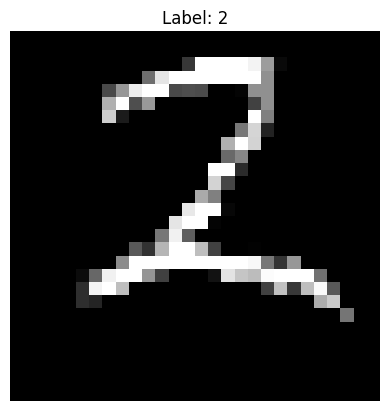

In [42]:
# Example of augmented data 
visualize_transformed_data(augmented_labeled_data, i=550)

#### 2.4. Model Training 

#### Test 1 : 
- "train_batch_size": 10, # smaller than unsup batch size
- "unsup_batch_size": 64,
- "eval_batch_size": 64,
- "learning_rate": 1e-4,
- "weight_decay": 0, 
- "train_steps": 1000,
- "uda_temp": 0.5,
- "unsup_coeff": 1, # 1 as suggested in the article
- "log_steps": 100,
- "eval_steps": 200


In [ ]:
# Configuration
config = {
    "train_batch_size": 10, # smaller than unsup batch size
    "unsup_batch_size": 64,
    "eval_batch_size": 64,
    "learning_rate": 5e-5, 
    "weight_decay": 0, 
    "train_steps": 4000,
    "uda_temp": 0.5, # according to the article : setting the Softmax temperature to 0.7, 0.8 or 0.9 leads to the best performances.
    "unsup_coeff": 1, # 1 as suggested in the article
    "log_steps": 100,
    "eval_steps": 200
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()

# Initialize the trainer and train the model
trainer = SemiSupervisedTrainer(model, device, config)
trainer.train(labeled_dataset, unlabeled_dataset, validation_dataset)


#### Test 1 : Model evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.97      0.99      0.98      1135
           2       0.91      0.92      0.92      1032
           3       0.79      0.83      0.81      1010
           4       0.96      0.80      0.87       982
           5       0.86      0.44      0.58       892
           6       0.95      0.92      0.93       958
           7       0.89      0.93      0.91      1028
           8       0.66      0.90      0.76       974
           9       0.82      0.86      0.84      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.85     10000
weighted avg       0.87      0.86      0.86     10000



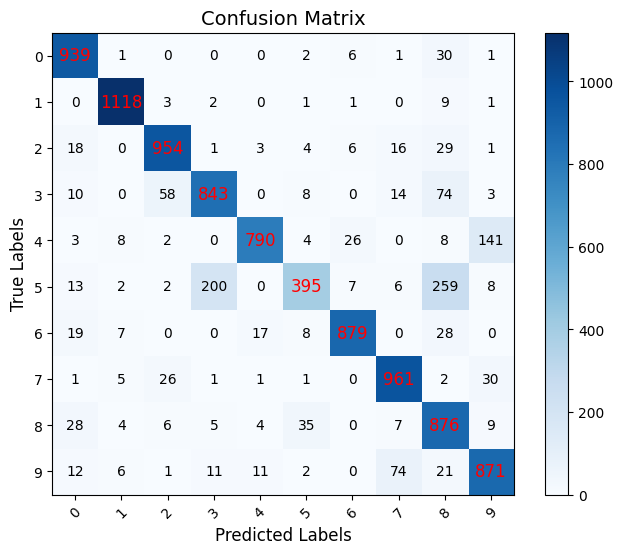

In [62]:
# Create DataLoader for test set
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

# Evaluation of our model 
evaluate_test_data(model, test_loader, device)

#### 2.5. Hyperparameter Finetuning 

##### Note 
- According to the article : We use a cosine learning rate decay schedule: cos( 7t/8T 2) where t is the current step and T is the total number of steps.
However, we decided to use our own cooked adaptative learning rate based on the evolution of the loss on the validation data.

##### Test with unsup_coeff = 1.1

Step [0/5000]: Total Loss = 2.3507, Supervised Loss = 2.3146, Unsupervised Loss = 0.0328
Step [100/5000]: Total Loss = 2.2338, Supervised Loss = 2.1892, Unsupervised Loss = 0.0405
Step [100/5000]: Validation Loss = 2.2133
Step [200/5000]: Total Loss = 2.1625, Supervised Loss = 2.0833, Unsupervised Loss = 0.0721
Step [200/5000]: Validation Loss = 2.1347
Step [300/5000]: Total Loss = 2.1085, Supervised Loss = 1.9539, Unsupervised Loss = 0.1405
Step [300/5000]: Validation Loss = 2.0352
Step [400/5000]: Total Loss = 2.1373, Supervised Loss = 1.8893, Unsupervised Loss = 0.2254
Step [400/5000]: Validation Loss = 1.9756
Step [500/5000]: Total Loss = 2.1155, Supervised Loss = 1.8768, Unsupervised Loss = 0.2170
Step [500/5000]: Validation Loss = 1.9655
Step [600/5000]: Total Loss = 2.1489, Supervised Loss = 1.8577, Unsupervised Loss = 0.2648
Step [600/5000]: Validation Loss = 1.9549
Step [700/5000]: Total Loss = 2.0092, Supervised Loss = 1.7610, Unsupervised Loss = 0.2256
Step [700/5000]: Valid

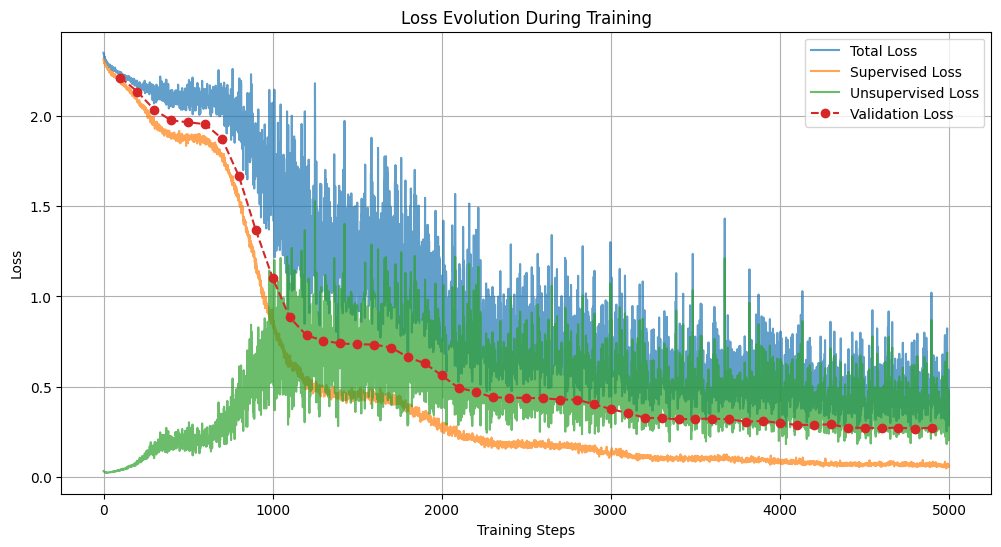

In [76]:
# Configuration
config2 = {
    "train_batch_size": 10, # smaller than unsup batch size
    "unsup_batch_size": 64,
    "eval_batch_size": 64,
    "learning_rate": 5e-5, 
    "weight_decay": 0, 
    "train_steps": 5000,
    "uda_temp": 0.3, # according to the article : setting the Softmax temperature to 0.7, 0.8 or 0.9 leads to the best performances.
    "unsup_coeff": 1.1, # 1 as suggested in the article
    "log_steps": 100,
    "eval_steps": 100
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5 = Net()

# Initialize the trainer and train the model
trainer4 = SemiSupervisedTrainer(model5, device, config2)
trainer4.train(labeled_dataset, unlabeled_dataset, validation_dataset)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.99      0.98      0.98      1135
           2       0.92      0.95      0.93      1032
           3       0.90      0.82      0.86      1010
           4       0.97      0.82      0.89       982
           5       0.97      0.48      0.64       892
           6       0.89      0.96      0.93       958
           7       0.95      0.93      0.94      1028
           8       0.60      0.96      0.74       974
           9       0.88      0.90      0.89      1009

    accuracy                           0.88     10000
   macro avg       0.90      0.88      0.88     10000
weighted avg       0.90      0.88      0.88     10000



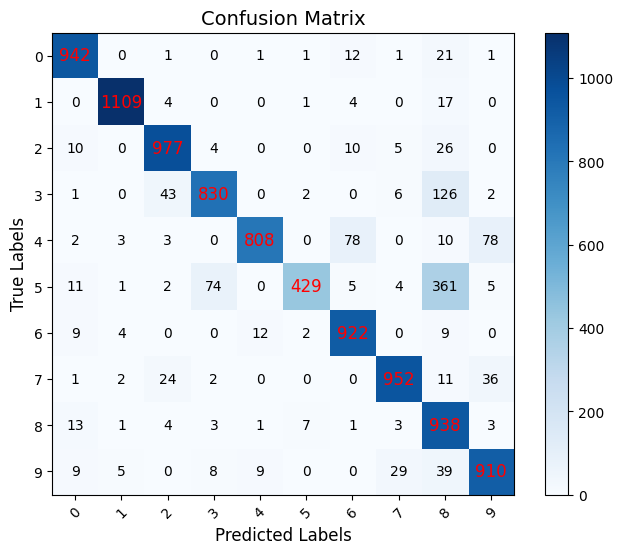

In [77]:
test_loader = DataLoader(testset, batch_size=64, shuffle=False)
evaluate_test_data(model5, test_loader, device)

##### We keep this final model achieving an accuracy of 0.88

### 3. New model and new analysis

#### 3.1. Data Preprocessing 

In [72]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])

batch_size = 64

dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

Spliting the training set into labeled and unlabeled data with :
- labeled data : 100 
- unlabeled data : 59 900 = 60 000 - 100

In [73]:
from collections import defaultdict

# Collect indices for each class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

# Ensure reproducibility
random.seed(42)

# Sample exactly 10 indices per class for labeled data
labeled_indices = []
for label in range(10):  # Iterate through each class
    labeled_indices.extend(random.sample(class_indices[label], 10))

# Remaining indices are for unlabeled data
all_indices = set(range(len(dataset)))
unlabeled_indices = list(all_indices - set(labeled_indices))

# Create subsets
labeled_data = torch.utils.data.Subset(dataset, labeled_indices)
unlabeled_data = torch.utils.data.Subset(dataset, unlabeled_indices)

# Check class counts in labeled data
from collections import Counter
class_counts = Counter([labeled_data[i][1] for i in range(len(labeled_data))])
print("Class counts in labeled data:", class_counts)

print("Size of the labeled data:", len(labeled_data))
print("Size of the unlabeled data:", len(unlabeled_data))

Class counts in labeled data: Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10})
Size of the labeled data: 100
Size of the unlabeled data: 59900


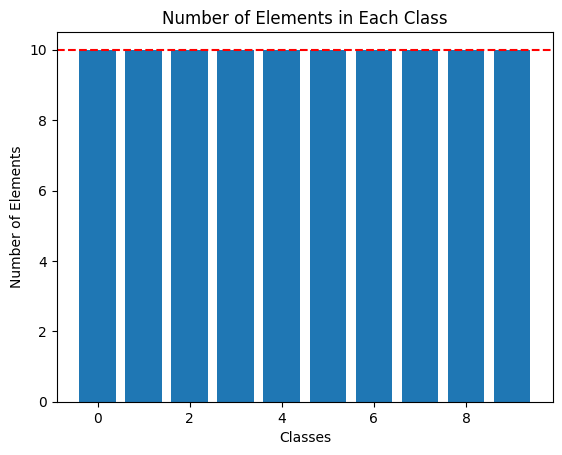

In [74]:
class_counts = Counter([labeled_data[i][1] for i in range(len(labeled_data))])
class_counts

# Visualization with barplot 

# Extracting the classes and their counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Creating the barplot
plt.bar(classes, counts)

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Elements')
# Adding a horizontal line at y=5 (for example) 
plt.axhline(y=len(stratified_subset)/len(classes), color='r', linestyle='--')
plt.title('Number of Elements in Each Class')

# Display the plot
plt.show()

Spliting the labeled set into training labeled and validation data with :
- labeled_train : 90
- validation_data : 10

In [75]:
# Ensure reproducibility
random.seed(42)

# Group labeled data indices by class
labeled_class_indices = defaultdict(list)
for idx, (_, label) in enumerate(labeled_data):
    labeled_class_indices[label].append(idx)

# Create validation set with one example per class
validation_indices = []
for label in range(10):  # Iterate through each class
    validation_indices.append(random.choice(labeled_class_indices[label]))
    # Remove selected index from labeled_class_indices
    labeled_class_indices[label].remove(validation_indices[-1])

# Remaining indices are for the labeled_train set
labeled_train_indices = []
for label, indices in labeled_class_indices.items():
    labeled_train_indices.extend(indices)

# Create subsets
labeled_train = torch.utils.data.Subset(labeled_data, labeled_train_indices)
validation_data = torch.utils.data.Subset(labeled_data, validation_indices)

# Check class counts in validation data
validation_class_counts = Counter([validation_data[i][1] for i in range(len(validation_data))])
print("Class counts in validation data:", validation_class_counts)

print("Size of the labeled_train data:", len(labeled_train))
print("Size of the validation data:", len(validation_data))

Class counts in validation data: Counter({0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1})
Size of the labeled_train data: 90
Size of the validation data: 10


Data augmentation 
- RandomRotation(10): Rotates images randomly by ±10 degrees.
- RandomAffine(0, translate=(0.1, 0.1)): Applies random translation to images.
- Normalize((0.5,), (0.5,)): Normalizes pixel values to have mean 0 and standard deviation 1.

In [77]:
# Define augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

# Custom dataset to handle augmentation and replication
class AugmentedDataset():
    def __init__(self, subset, transform, target_size):
        self.subset = subset
        self.transform = transform
        self.target_size = target_size
        self.num_repeats = target_size // len(subset) + 1  # Number of times to repeat each item

    def __getitem__(self, index):
        # Map index to original subset and repeat augmentation
        original_idx = index % len(self.subset)
        image, label = self.subset[original_idx]
        
        # Apply augmentation
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return self.target_size

# Create augmented datasets
target_train_size = 5000
target_val_size = 500

augmented_labeled_train = AugmentedDataset(labeled_train, train_transform, target_train_size)
augmented_validation = AugmentedDataset(validation_data, val_transform, target_val_size)

# Create data loaders
labeled_train_loader = DataLoader(augmented_labeled_train, batch_size=64, shuffle=True)
val_loader = DataLoader(augmented_validation, batch_size=64, shuffle=False)

# Test the loaders
for images, labels in labeled_train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels:", labels)
    break

for images, labels in val_loader:
    print("Validation batch shape:", images.shape)
    print("Validation batch labels:", labels)
    break


Batch of images shape: torch.Size([64, 1, 28, 28])
Batch of labels: tensor([3, 4, 4, 1, 2, 5, 3, 5, 1, 8, 6, 2, 8, 5, 1, 2, 6, 8, 9, 5, 6, 8, 2, 5,
        2, 0, 4, 4, 5, 1, 5, 6, 8, 6, 8, 3, 0, 0, 5, 4, 8, 0, 8, 0, 9, 8, 4, 1,
        5, 5, 9, 5, 0, 7, 6, 5, 6, 3, 8, 8, 9, 1, 6, 3])
Validation batch shape: torch.Size([64, 1, 28, 28])
Validation batch labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3])


In [78]:
# Check class counts in augmauted data
augmented_class_counts = Counter([augmented_labeled_train[i][1] for i in range(len(augmented_labeled_train))])
print("Class counts in validation data:", augmented_class_counts)

Class counts in validation data: Counter({0: 504, 1: 504, 2: 504, 3: 504, 4: 504, 5: 500, 6: 495, 7: 495, 8: 495, 9: 495})


#### 3.2. Building new model (more complex)

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F

class BestMNISTCNN(nn.Module):
    def __init__(self):
        super(BestMNISTCNN, self).__init__()
        # First Block
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv1_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=2)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.bn1_3 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.3)  # Dropout for first block

        # Second Block
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv2_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=2)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.bn2_3 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)  # Dropout for second block

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After downsampling, feature map size is 7x7
        self.fc2 = nn.Linear(128, 10)
        self.dropout_fc = nn.Dropout(0.5)  # Dropout for fully connected layer

    def forward(self, x):
        # First Block
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.relu(self.bn1_3(self.conv1_3(x)))
        x = self.dropout1(x)  # Apply dropout

        # Second Block
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.relu(self.bn2_3(self.conv2_3(x)))
        x = self.dropout2(x)  # Apply dropout

        # Flatten for fully connected layers
        x = torch.flatten(x, 1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Apply dropout
        x = self.fc2(x)
        return x

#### 3.3. Baseline : Naive Training Model (only using 100 labeled data)

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
# Hyperparameters
epochs = 20
learning_rate = 0.0001

# Initialize model, loss, and optimizer
net = BestMNISTCNN().to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # Adam optimizer
output_fn = torch.nn.Softmax(dim=1)  # Softmax for probabilities

# Track loss and accuracy
loss_train, acc_train = [], []
loss_valid, acc_valid = [], []

# Training Loop
for epoch in tqdm(range(epochs), desc="Training Progress"):
    # ---- Training ----
    net.train()  # Set model to training mode
    running_loss = 0.0
    running_acc = 0.0
    
    for batch in labeled_train_loader:  # Loop over training batches
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item()
        preds = output_fn(outputs).argmax(dim=1).cpu().numpy()
        ground_truth = labels.cpu().numpy()
        running_acc += (preds == ground_truth).mean()

    # Compute epoch-level metrics
    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    loss_train.append(train_loss)
    acc_train.append(train_acc)

    # ---- Validation ----
    net.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0
    
    with torch.no_grad():  # Disable gradient calculations
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate metrics
            val_loss += loss.item()
            preds = output_fn(outputs).argmax(dim=1).cpu().numpy()
            ground_truth = labels.cpu().numpy()
            val_acc += (preds == ground_truth).mean()

    # Compute epoch-level validation metrics
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    loss_valid.append(val_loss)
    acc_valid.append(val_acc)

    # Print metrics for the epoch
    print(f"| Epoch: {epoch + 1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | "
          f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} |")


Training Progress:   5%|▌         | 1/20 [00:05<01:42,  5.40s/it]

| Epoch: 1/20 | Train Loss: 1.1800 | Train Accuracy: 0.1505 | Validation Loss: 1.3889 | Validation Accuracy: 0.6998 |


Training Progress:  10%|█         | 2/20 [00:11<01:40,  5.60s/it]

| Epoch: 2/20 | Train Loss: 0.6884 | Train Accuracy: 0.3409 | Validation Loss: 0.8578 | Validation Accuracy: 0.5999 |


Training Progress:  15%|█▌        | 3/20 [00:17<01:38,  5.78s/it]

| Epoch: 3/20 | Train Loss: 0.3855 | Train Accuracy: 0.4443 | Validation Loss: 0.3656 | Validation Accuracy: 0.8996 |


Training Progress:  20%|██        | 4/20 [00:23<01:34,  5.89s/it]

| Epoch: 4/20 | Train Loss: 0.2276 | Train Accuracy: 0.4945 | Validation Loss: 0.2586 | Validation Accuracy: 0.8996 |


Training Progress:  25%|██▌       | 5/20 [00:29<01:28,  5.93s/it]

| Epoch: 5/20 | Train Loss: 0.1355 | Train Accuracy: 0.5255 | Validation Loss: 0.2989 | Validation Accuracy: 0.8996 |


Training Progress:  30%|███       | 6/20 [00:34<01:20,  5.75s/it]

| Epoch: 6/20 | Train Loss: 0.0872 | Train Accuracy: 0.5392 | Validation Loss: 0.2227 | Validation Accuracy: 0.8996 |


Training Progress:  35%|███▌      | 7/20 [00:39<01:12,  5.56s/it]

| Epoch: 7/20 | Train Loss: 0.0614 | Train Accuracy: 0.5469 | Validation Loss: 0.3115 | Validation Accuracy: 0.8996 |


Training Progress:  40%|████      | 8/20 [00:44<01:05,  5.43s/it]

| Epoch: 8/20 | Train Loss: 0.0507 | Train Accuracy: 0.5486 | Validation Loss: 0.1442 | Validation Accuracy: 0.8996 |


Training Progress:  45%|████▌     | 9/20 [00:50<00:59,  5.42s/it]

| Epoch: 9/20 | Train Loss: 0.0317 | Train Accuracy: 0.5543 | Validation Loss: 0.1598 | Validation Accuracy: 0.8996 |


Training Progress:  50%|█████     | 10/20 [00:55<00:54,  5.45s/it]

| Epoch: 10/20 | Train Loss: 0.0256 | Train Accuracy: 0.5562 | Validation Loss: 0.2472 | Validation Accuracy: 0.8996 |


Training Progress:  55%|█████▌    | 11/20 [01:01<00:49,  5.48s/it]

| Epoch: 11/20 | Train Loss: 0.0239 | Train Accuracy: 0.5557 | Validation Loss: 0.3756 | Validation Accuracy: 0.8996 |


Training Progress:  60%|██████    | 12/20 [01:06<00:42,  5.36s/it]

| Epoch: 12/20 | Train Loss: 0.0208 | Train Accuracy: 0.5567 | Validation Loss: 0.1224 | Validation Accuracy: 0.8996 |


Training Progress:  65%|██████▌   | 13/20 [01:11<00:37,  5.33s/it]

| Epoch: 13/20 | Train Loss: 0.0160 | Train Accuracy: 0.5571 | Validation Loss: 0.1303 | Validation Accuracy: 1.0000 |


Training Progress:  70%|███████   | 14/20 [01:17<00:31,  5.31s/it]

| Epoch: 14/20 | Train Loss: 0.0152 | Train Accuracy: 0.5576 | Validation Loss: 0.2110 | Validation Accuracy: 0.8996 |


Training Progress:  75%|███████▌  | 15/20 [01:22<00:26,  5.39s/it]

| Epoch: 15/20 | Train Loss: 0.0129 | Train Accuracy: 0.5583 | Validation Loss: 0.3302 | Validation Accuracy: 0.8996 |


Training Progress:  80%|████████  | 16/20 [01:27<00:21,  5.34s/it]

| Epoch: 16/20 | Train Loss: 0.0104 | Train Accuracy: 0.5591 | Validation Loss: 0.3015 | Validation Accuracy: 0.8996 |


Training Progress:  85%|████████▌ | 17/20 [01:32<00:15,  5.29s/it]

| Epoch: 17/20 | Train Loss: 0.0106 | Train Accuracy: 0.5591 | Validation Loss: 0.0846 | Validation Accuracy: 1.0000 |


Training Progress:  90%|█████████ | 18/20 [01:38<00:10,  5.25s/it]

| Epoch: 18/20 | Train Loss: 0.0074 | Train Accuracy: 0.5596 | Validation Loss: 0.3624 | Validation Accuracy: 0.8996 |


Training Progress:  95%|█████████▌| 19/20 [01:43<00:05,  5.31s/it]

| Epoch: 19/20 | Train Loss: 0.0086 | Train Accuracy: 0.5586 | Validation Loss: 0.2454 | Validation Accuracy: 0.8996 |


Training Progress: 100%|██████████| 20/20 [01:48<00:00,  5.44s/it]

| Epoch: 20/20 | Train Loss: 0.0081 | Train Accuracy: 0.5588 | Validation Loss: 0.1348 | Validation Accuracy: 0.8996 |


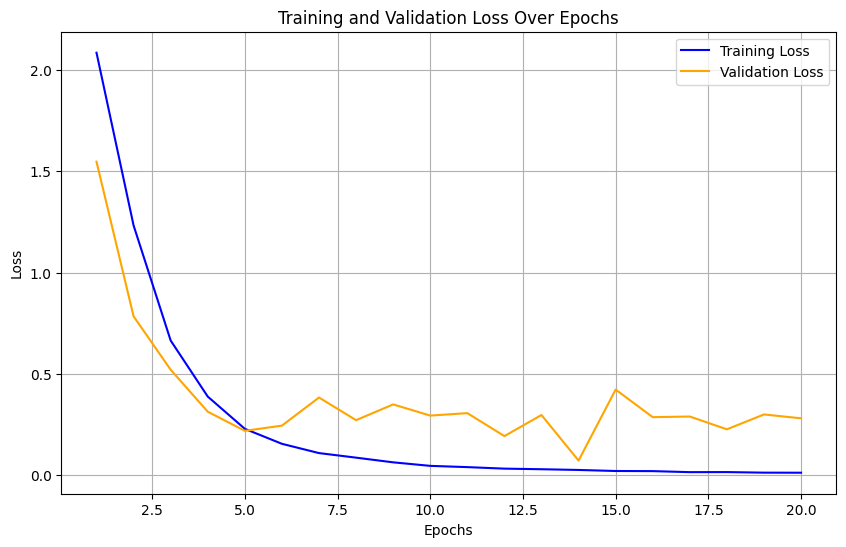

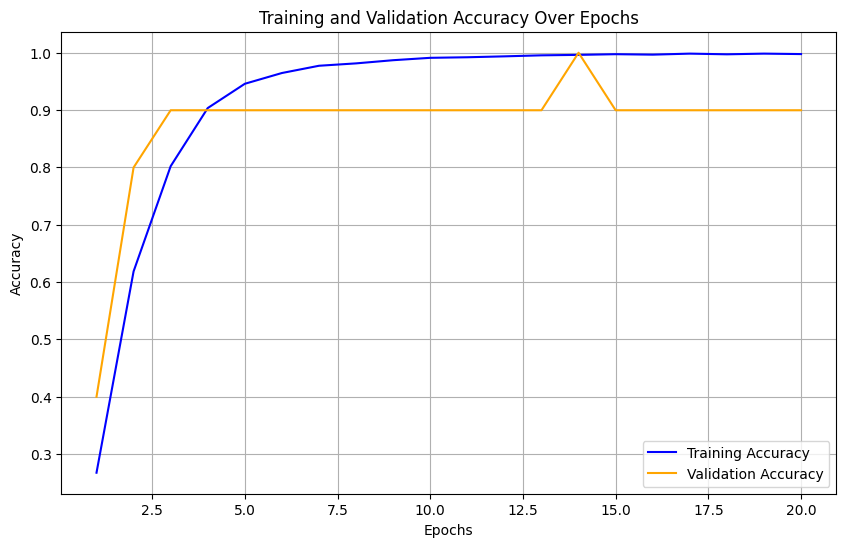

In [267]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_train, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), loss_valid, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), acc_train, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), acc_valid, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### Baseline : Evaluation of the naive model 

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       1.00      0.00      0.01       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       1.00      0.01      0.02      1028
           8       0.14      0.85      0.25       974
           9       0.21      0.68      0.32      1009

    accuracy                           0.23     10000
   macro avg       0.31      0.23      0.13     10000
weighted avg       0.31      0.23      0.13     10000



c:\Users\jaadb\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jaadb\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jaadb\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


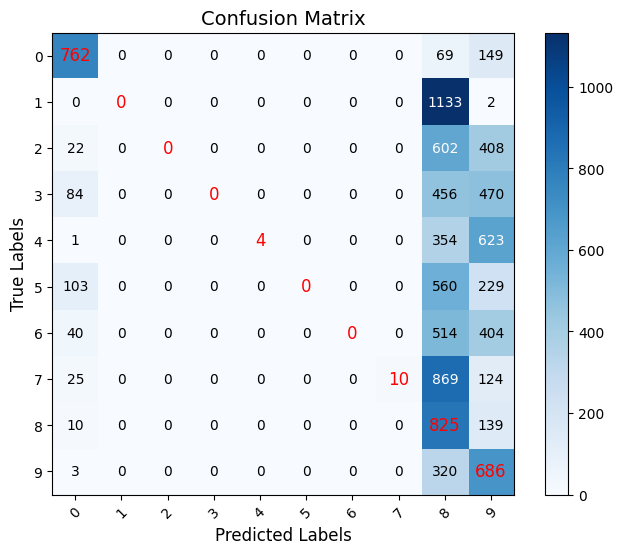

In [268]:
test_loader = DataLoader(testset, batch_size=64, shuffle=False)
evaluate_test_data(net, test_loader, device)

#### 3.3. UDA technique

Step [0/4500]: Total Loss = 2.7419, Supervised Loss = 2.3628, Unsupervised Loss = 0.3446
Step [100/4500]: Total Loss = 2.1647, Supervised Loss = 1.8445, Unsupervised Loss = 0.2911
Step [100/4500]: Validation Loss = 2.0147
Step [200/4500]: Total Loss = 1.7923, Supervised Loss = 1.2167, Unsupervised Loss = 0.5233
Step [200/4500]: Validation Loss = 1.5516
Step [300/4500]: Total Loss = 1.7125, Supervised Loss = 0.9590, Unsupervised Loss = 0.6851
Step [300/4500]: Validation Loss = 1.3568
Step [400/4500]: Total Loss = 1.5876, Supervised Loss = 0.8720, Unsupervised Loss = 0.6506
Step [400/4500]: Validation Loss = 1.2810
Step [500/4500]: Total Loss = 1.8047, Supervised Loss = 0.9318, Unsupervised Loss = 0.7936
Step [500/4500]: Validation Loss = 1.2941
Step [600/4500]: Total Loss = 1.4644, Supervised Loss = 0.8020, Unsupervised Loss = 0.6021
Step [600/4500]: Validation Loss = 1.2528
Step [700/4500]: Total Loss = 1.4339, Supervised Loss = 0.7295, Unsupervised Loss = 0.6403
Step [700/4500]: Valid

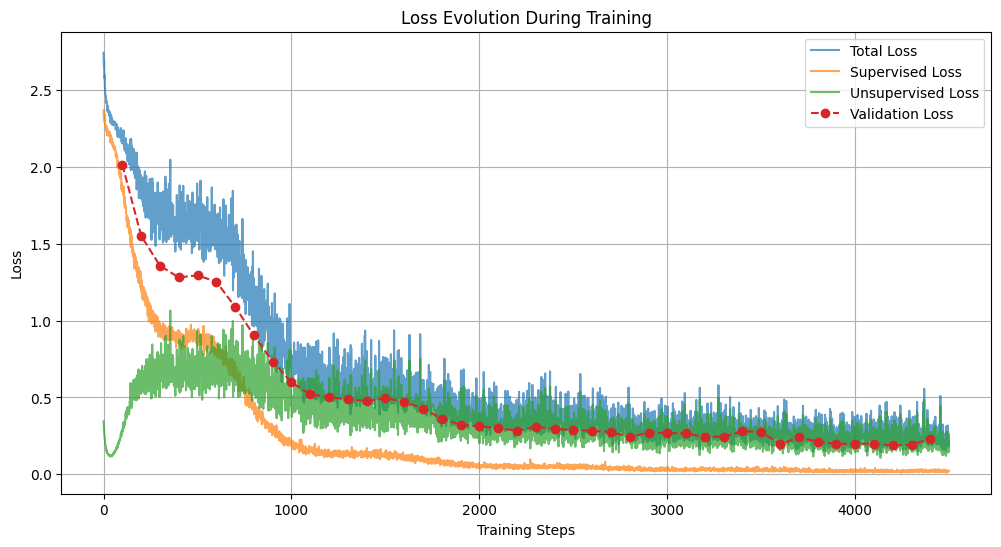

In [98]:
# Configuration
config = {
    "train_batch_size": 10, # smaller than unsup batch size
    "unsup_batch_size": 64,
    "eval_batch_size": 64,
    "learning_rate": 5e-5, 
    "weight_decay": 0, 
    "train_steps": 4500,
    "uda_temp": 0.4, # according to the article : setting the Softmax temperature to 0.7, 0.8 or 0.9 leads to the best performances.
    "unsup_coeff": 1.1, # 1 as suggested in the article
    "log_steps": 100,
    "eval_steps": 100
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_best4 = BestMNISTCNN()

# Initialize the trainer and train the model
trainer2 = SemiSupervisedTrainer(model_best4, device, config)
trainer2.train(labeled_data, unlabeled_data, validation_dataset)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.99      0.95      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.97      0.98       892
           6       0.96      0.98      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.92      0.96      0.94      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



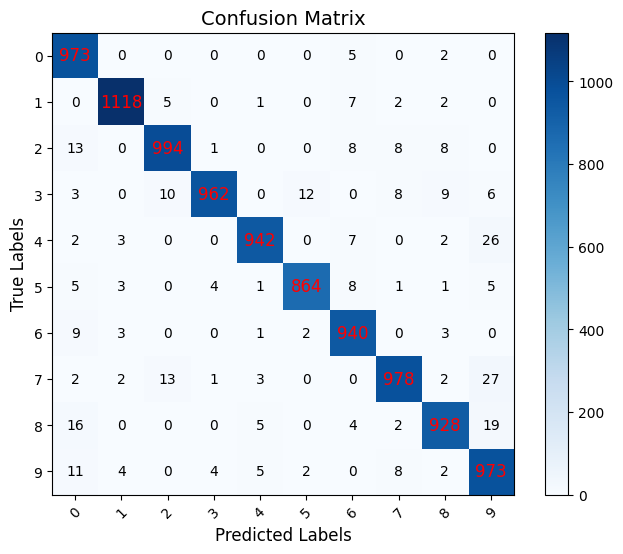

In [99]:
test_loader = DataLoader(testset, batch_size=64, shuffle=False)
evaluate_test_data(model_best4, test_loader, device)

#### New try 

### 4. Additional training techniques

#### 4.1. Sharpening prediction class  

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from itertools import cycle

class SemiSupervisedTrainerWithBeta:
    def __init__(self, model, device, config):
        self.model = model.to(device)
        self.device = device
        self.config = config

        # Define the optimizer, scheduler, and loss functions
        self.optimizer = optim.SGD(
            model.parameters(),
            lr=config["learning_rate"],
            momentum=0.9,
            weight_decay=config["weight_decay"],
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=config["train_steps"]
        )
        self.supervised_criterion = nn.CrossEntropyLoss()
        self.kl_divergence = nn.KLDivLoss(reduction="batchmean")

        # Initialize lists to store losses
        self.training_loss_history = []
        self.supervised_loss_history = []
        self.unsupervised_loss_history = []
        self.validation_loss_history = []

    def train(self, labeled_dataset, unlabeled_dataset, val_dataset):
        labeled_loader = DataLoader(
            labeled_dataset,
            batch_size=self.config["train_batch_size"],
            shuffle=True
        )
        unlabeled_loader = DataLoader(
            unlabeled_dataset,
            batch_size=self.config["unsup_batch_size"],
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=self.config["eval_batch_size"], 
            shuffle=False
        )

        unlabeled_iter = cycle(unlabeled_loader)

        for step in range(self.config["train_steps"]):
            self.model.train()

            total_loss_accumulator = 0.0
            supervised_loss_accumulator = 0.0
            unsupervised_loss_accumulator = 0.0
            batch_count = 0

            for labeled_data in labeled_loader:
                images_sup, labels_sup = labeled_data
                images_sup, labels_sup = images_sup.to(self.device), labels_sup.to(self.device)

                # Fetch a batch of unlabeled data
                images_unsup = next(unlabeled_iter)
                if isinstance(images_unsup, (list, tuple)):
                    images_unsup = images_unsup[0]
                images_unsup = images_unsup.to(self.device)

                # Supervised loss
                logits_sup = self.model(images_sup)
                supervised_loss = self.supervised_criterion(logits_sup, labels_sup)

                # Unsupervised loss with thresholding
                with torch.no_grad():
                    logits_ori = self.model(images_unsup)
                    probs_ori = torch.softmax(logits_ori, dim=-1)
                    max_probs, _ = torch.max(probs_ori, dim=-1)

                # Apply the threshold condition
                mask = max_probs > self.config["Beta"]
                selected_indices = torch.nonzero(mask).squeeze()
                if selected_indices.numel() > 0:
                    logits_selected = logits_ori[selected_indices]
                    probs_selected = probs_ori[selected_indices]

                    # Data augmentation for selected examples
                    images_selected = images_unsup[selected_indices]
                    images_selected_uint8 = (images_selected * 255).clamp(0, 255).to(torch.uint8)
                    augmented_images = transforms.RandAugment(num_ops=2, magnitude=9)(images_selected_uint8)
                    augmented_images = augmented_images.to(torch.float32) / 255.0
                    augmented_images = transforms.Normalize((0.5,), (0.5,))(augmented_images).to(self.device)

                    logits_aug = self.model(augmented_images)

                    # Compute unsupervised loss
                    unsup_loss = self.kl_divergence(
                        torch.log_softmax(logits_aug / self.config["uda_temp"], dim=-1),
                        probs_selected
                    )
                else:
                    unsup_loss = torch.tensor(0.0, device=self.device)

                # Combine losses
                total_loss = supervised_loss + self.config["unsup_coeff"] * unsup_loss

                # Accumulate losses
                total_loss_accumulator += total_loss.item()
                supervised_loss_accumulator += supervised_loss.item()
                unsupervised_loss_accumulator += unsup_loss.item()
                batch_count += 1

                # Backpropagation
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            # Compute average losses for the step
            avg_total_loss = total_loss_accumulator / batch_count
            avg_supervised_loss = supervised_loss_accumulator / batch_count
            avg_unsupervised_loss = unsupervised_loss_accumulator / batch_count

            # Store the losses
            self.training_loss_history.append(avg_total_loss)
            self.supervised_loss_history.append(avg_supervised_loss)
            self.unsupervised_loss_history.append(avg_unsupervised_loss)

            if step % self.config["log_steps"] == 0:
                print(
                    f"Step [{step}/{self.config['train_steps']}]: "
                    f"Total Loss = {avg_total_loss:.4f}, "
                    f"Supervised Loss = {avg_supervised_loss:.4f}, "
                    f"Unsupervised Loss = {avg_unsupervised_loss:.4f}"
                )

            if step % self.config["eval_steps"] == 0 and step > 0:
                val_loss = self.evaluate(val_loader)
                self.validation_loss_history.append(val_loss)
                print(
                    f"Step [{step}/{self.config['train_steps']}]: "
                    f"Validation Loss = {val_loss:.4f}"
                )

        print("Training complete.")
        self.plot_losses()

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.supervised_criterion(outputs, labels)
                total_loss += loss.item() * labels.size(0)
                total += labels.size(0)

        avg_loss = total_loss / total
        self.model.train()
        return avg_loss

    def plot_losses(self):
        steps = range(len(self.training_loss_history))
        plt.figure(figsize=(12, 6))
        plt.plot(steps, self.training_loss_history, label="Total Loss", alpha=0.7)
        plt.plot(steps, self.supervised_loss_history, label="Supervised Loss", alpha=0.7)
        plt.plot(steps, self.unsupervised_loss_history, label="Unsupervised Loss", alpha=0.7)

        eval_steps = [
            step for step in range(self.config["eval_steps"], self.config["train_steps"] + 1, self.config["eval_steps"])
        ][:len(self.validation_loss_history)]

        plt.plot(eval_steps, self.validation_loss_history, label="Validation Loss", marker="o", linestyle="--")

        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.title("Loss Evolution During Training")
        plt.legend()
        plt.grid(True)
        plt.show()


#### Unfortunatly we didn't find how to make this class works. We will keep our final model achieving 0.97 accuracy 